# Importing libraries

In [36]:
import warnings
# Librerias para la visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Librerias para manejar datos
import numpy as np
import pandas as pd
# Librerias para el procesamiento de lenguaje natural re (expresiones regulares) y nltk (NLP)
import re
import nltk
# Herramientas para NLP como stopwords , Lematizador , Vectorizador , Codificador
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
#Herramientas para entrenamiento del modelo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# Modelos de Random Forest y KNN (Clasificadores)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Herramientas para la evaluacion
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix


## Data load

The team considers it necessary to mention that a generic data set "spam.csv" is used as a model test, which includes paragraphs or sentences with a variety of words (size).

In [4]:
data = pd.read_csv("../datasets/spam.csv", encoding="ISO-8859-1")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Dropping irrelevant columns

In [5]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Rename Columns
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Feature engineering

The code in this section represents the exploration of features and creation of new assets in the data like:
* No_of_Characters: Number of characters
* No_of_Words: Number of words
* No_of_sentence: Number of sentences

In [6]:
#Dowload of Punk Sentence Tokenizer
# Tokenizer divides text in sentences
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alonx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#Adding new columns (features)
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"] = data.apply(
    lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len) #Tokenization of Text words
data["No_of_sentence"] = data.apply(
    lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len) #Tokenization of  Text sentences

data.describe().T


,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


Even as just a test , the data could contain non-typical values 

<Figure size 864x576 with 0 Axes>

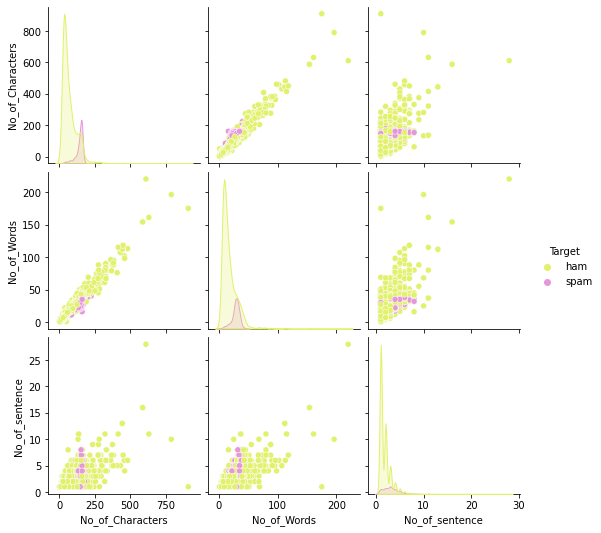

In [9]:
plt.figure(figsize=(12, 8))
cols= ["#E1F16B", "#E598D8"]
fg = sns.pairplot(data=data, hue="Target", palette=cols)
plt.show(fg)


We set the number of characters (due to so much non-typical values) to less than 350 per row

In [10]:
#Eliminando los valores atípicos
data = data[(data["No_of_Characters"] < 350)]
data.shape

(5548, 5)

## Data preprocessing

The data cleansing process in Natural Language Processing (NLP) is crucial. Without it, the computer does not understand the text and interprets it as a meaningless set of symbols. For more complex data processing we require data cleansing compulsorily.

* First stage: Extract alphabetical characters then punctuations and numbers
* Second stage: Lowercase characters

In [11]:
# Clean function definition
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #The regular expression of [^a-zA-Z] replaces non alphabetical into blanks
    sms = sms.lower() #Lowercase convertion
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

#New column for clean text
data["Clean_Text"] = data["Text"].apply(Clean)

C:\Users\alonx\AppData\Local\Temp\ipykernel_14264\1638985348.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Clean_Text"] = data["Text"].apply(Clean)


# Tokenization

Tokenization is about spliting complex data in little units called tokens . In this case , pharagraphs into words and sentences into words

In [12]:
# Applying lambda function for tokenization
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

C:\Users\alonx\AppData\Local\Temp\ipykernel_14264\2060678700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)


## Stopwords

Stopwords are words with high frecuency but with no special contribution to NLP (like , no , few) . NLTK library has default stopwords for elimination

In [13]:
# Stopwords delete function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

C:\Users\alonx\AppData\Local\Temp\ipykernel_14264\3618625640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)


## Lemmatization

This process is about obtaining the core of the words , but ensuring the correct translation

In [14]:
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alonx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alonx\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
# Defining the lemmatizer parameter
lemmatizer = WordNetLemmatizer()

# Function for lemmatize a word
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

#New column with lemmatize text
data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)


C:\Users\alonx\AppData\Local\Temp\ipykernel_14264\4018786665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)


## Vectorization

TF-IDF in NLP stands for Term Frequency: Inverse Document Frequency. In NLP, clean data must be converted to a numeric format where each word is represented by a matrix. This is also known as word embedding or word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in the documents) Inverse Document Frequency (IDF) = log ((Total number of documents)/(Number of documents with the term t)) I'll use TfidfVectorizer() to vectorize the preprocessed data.

Steps in Vectorization:

* Creation of a lemmatized text corpus.
* Convert the corpus to vector form
* Label encoding of classes in Target

In [16]:
# Function for create corpus (More vectorized text)
corpus = []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)


Converting text into numbers by Vectorizer

In [17]:
tfidf = TfidfVectorizer()
#Creating an X data section (Independent variables)
X = tfidf.fit_transform(corpus).toarray()

Creating the Y variable , the target of spam or non-spam

In [18]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

C:\Users\alonx\AppData\Local\Temp\ipykernel_14264\275600629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = label_encoder.fit_transform(data["Target"])


## Contruction of classifiers

Defining the Y , the target and sets for training

In [19]:
y = data["Target"] 
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Model

In [21]:
rf = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=5,min_samples_leaf=2,max_features='auto',random_state=42)
rf.fit(X_train,y_train)

c:\Users\alonx\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, random_state=42)

### KNN Model

In [25]:
knn = KNeighborsClassifier(n_neighbors=5,weights='uniform',n_jobs=-1,algorithm='auto')
knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1)

# Model Testing

In [27]:
#Creating metrics for both models
precision =[]
recall =[]
f1_score = []

#List of models
classifiers = [rf,knn]

# Evaluating each model
for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)

  
    # Results
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)

Now for the testing we shall initiate a list of the metrics

In [28]:
evaluation = {'Precision':precision,
'Recall':recall,
'F1score':f1_score}
# Creando dataframe en pandas
Results = pd.DataFrame(evaluation, index =[ "RandomForest", "KNeighbours"])

The results dataframe is shown in colors

In [41]:
cmap2 = ListedColormap(["#E2CCFF", "#E598D8"])
Results.style.background_gradient(cmap=cmap2)


,Precision,Recall,F1score
RandomForest,1.000000,0.176471,0.300000
KNeighbours,0.977778,0.323529,0.486188


Finally , a graphic of the evaluation for both models

c:\Users\alonx\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alonx\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


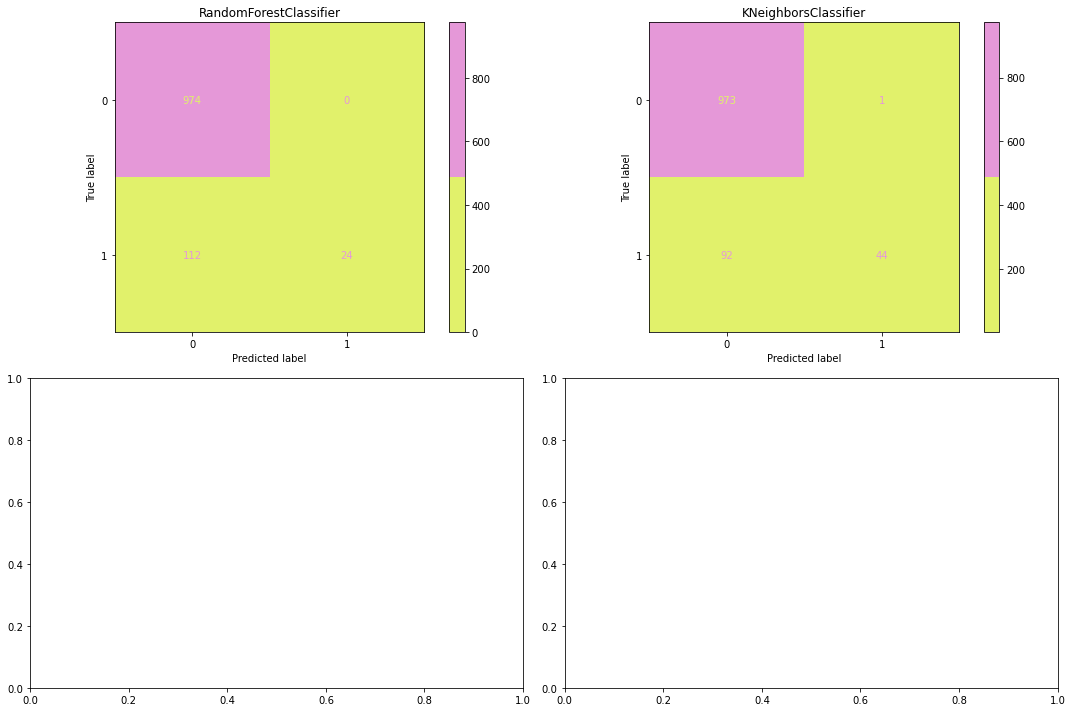

In [42]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls,
                          X_test,
                          y_test,
                          ax=ax,
                          cmap=cmap,
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()


Note: Conclusions of testing are documented in the respective data issue 